A simple try of VAE with linear layers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data_buf = np.load('data.npy')
index_buf = np.load('index.npy')
data = data_buf[53, :1055000]
index = index_buf[index_buf < 1055000].astype(int) 
print(data.shape)
print(index)

(1055000,)
[  25351   32967   65124  110605  110614  139796  139803  179850  179858
  220048  231137  245534  270780  270789  309584  429010  477457  483625
  483633  520625  525407  525415  536316  536324  565340  689253  713584
  720463  725368  807271  852387  923113  972713  985866 1009480 1046297
 1052564]


In [2]:
import torch
from torch import nn
import numpy as np

# set window size
window_size = 600 # 600 samples = 20ms

# generate complex spikes samples
def generate_samples(data, index, window_size):
    samples = []
    for i in index:
        if i - window_size >= 0 and i + window_size < len(data):
            sample = data[i - window_size:i + window_size]
            samples.append(sample)
    return np.array(samples)

# generate non-complex spikes samples
def generate_non_spikes_samples(data, index, window_size, num_samples):
    non_spikes_samples = []
    available_indices = set(range(window_size, len(data) - window_size)) - set(index)
    selected_indices = np.random.choice(list(available_indices), num_samples, replace=False)
    
    for i in selected_indices:
        sample = data[i - window_size:i + window_size]
        non_spikes_samples.append(sample)
    
    return np.array(non_spikes_samples)

spikes_samples = generate_samples(data, index, window_size)
non_spikes_samples = generate_non_spikes_samples(data, index, window_size, len(index))
spikes_samples = torch.tensor(spikes_samples, dtype=torch.float32)
non_spikes_samples = torch.tensor(non_spikes_samples, dtype=torch.float32)

# shuffle & concatenat
all_samples = torch.cat((spikes_samples, non_spikes_samples), dim=0)
all_samples = all_samples[torch.randperm(all_samples.size(0))]

# define linear VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = x.chunk(2, dim=-1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var
    
input_dim = window_size * 2
latent_dim = 50  # latent_dim should be adjusted according to the data
model = VAE(input_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# define vae loss?
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kld

epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    recon_batch, mu, log_var = model(all_samples)
    loss = vae_loss(recon_batch, all_samples, mu, log_var)
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:  # print loss every 20 epochs
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# save model
torch.save(model.state_dict(), 'vae_model.pth')

Epoch 1, Loss: 110444560.0
Epoch 21, Loss: 27969498.0
Epoch 41, Loss: 27827696.0
Epoch 61, Loss: 27762990.0
Epoch 81, Loss: 27715996.0
Epoch 101, Loss: 27669962.0
Epoch 121, Loss: 27631302.0
Epoch 141, Loss: 27604690.0
Epoch 161, Loss: 27584220.0
Epoch 181, Loss: 27566354.0


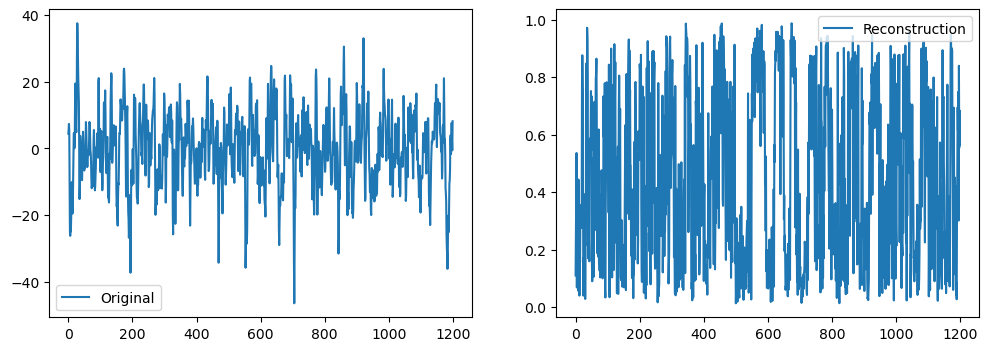

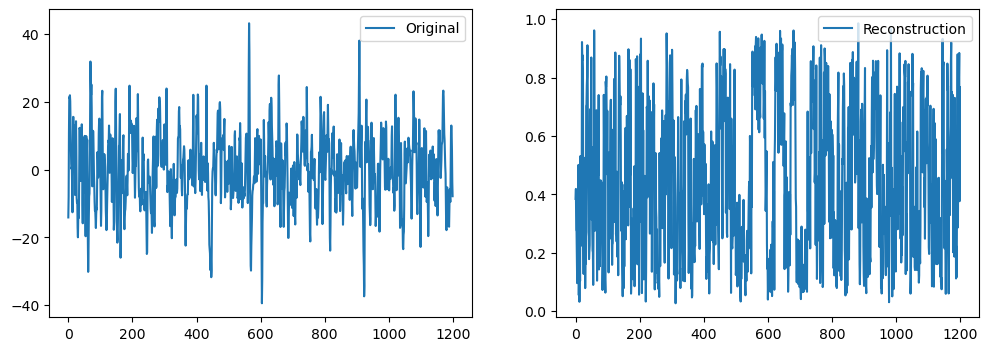

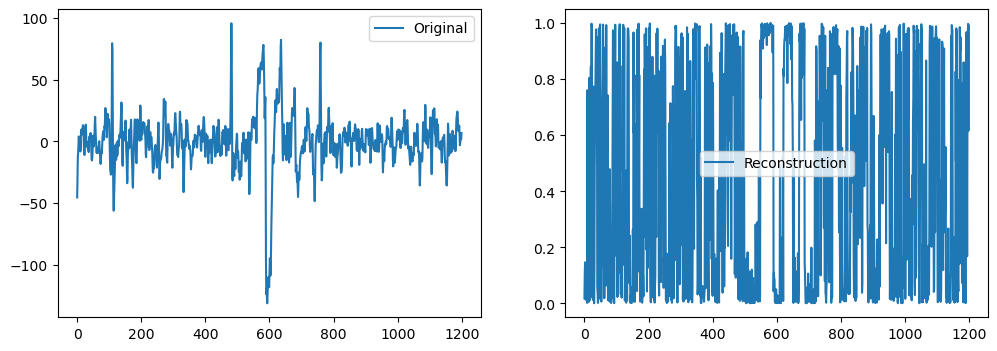

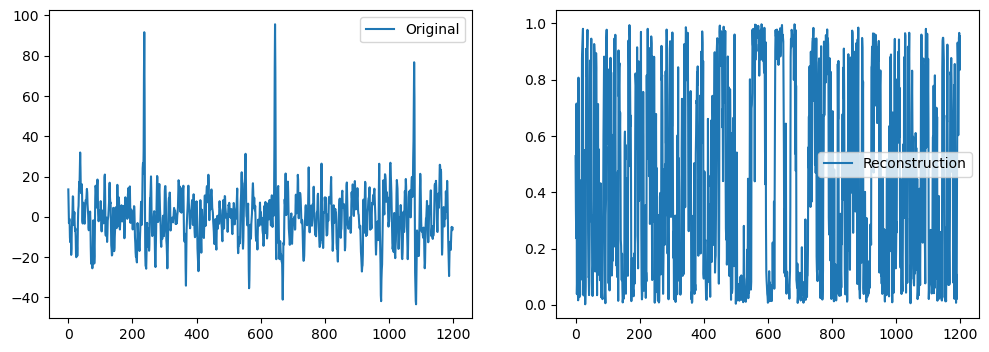

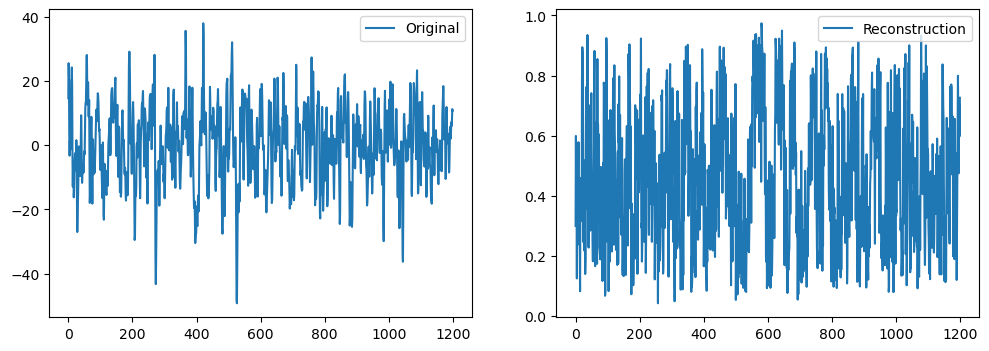

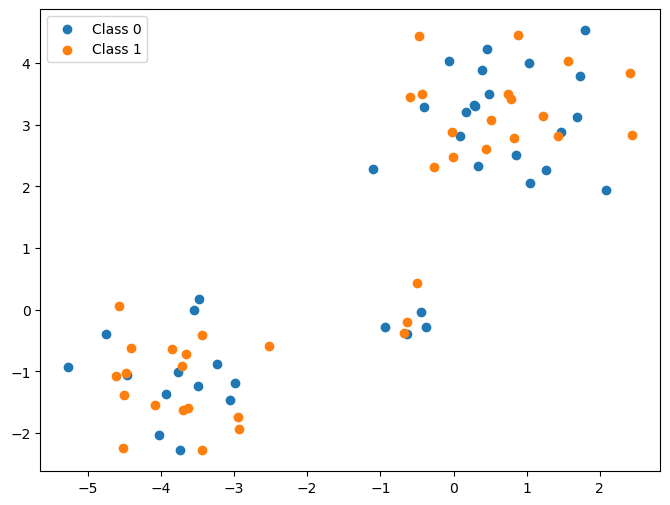

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# reconstruct samples visualization
def visualize_reconstruction(model, samples, num_samples=5):
    model.eval()
    with torch.no_grad():
        reconstructions, _, _ = model(samples[:num_samples])
    
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(samples[i].numpy(), label='Original')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(reconstructions[i].numpy(), label='Reconstruction')
        plt.legend()
        plt.show()

visualize_reconstruction(model, all_samples)

def visualize_latent_space(model, samples, labels):
    model.eval()
    with torch.no_grad():
        _, mu, _ = model(samples)
    tsne = TSNE(n_components=2, random_state=0)
    z_tsne = tsne.fit_transform(mu.numpy())
    
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(z_tsne[indices, 0], z_tsne[indices, 1], label=f'Class {label}')
    plt.legend()
    plt.show()

# assume the first half of the samples are complex spikes, and the second half are non-complex spikes
labels = np.array([0]*len(spikes_samples) + [1]*len(non_spikes_samples))
visualize_latent_space(model, all_samples, labels)